Alumno: Erick Salvador Alvarez Valencia

## Histograma y ecualización

Se importan los módulos necesarios y se define una función de normalización para las imágenes.

In [1]:
import numpy as np
import skimage
from skimage import data
from skimage.color.adapt_rgb import adapt_rgb, each_channel
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def normalize_img(img):
    img = (img - img.min()) / (img.max() - img.min()) * 255.0
    return np.array(img, dtype = 'uint8')
    
%matplotlib inline

In [2]:
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage import img_as_float

Se crean las funciones base, el cálculo del histograma, la función de probabilidad acumulada y la función de ecualización.
Estas funciones están hechas para procesar tanto imágenes a color (canales por separado) como imágenes en escala de grises.

In [3]:
def histogram(img, channel):
    data = np.zeros(256, dtype = 'int')
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if channel != -1:
                data[img[i, j, channel]] += 1
            else:
                data[img[i, j]] += 1
    
    return data

def create_paf(img, channel):
    n, m = img.shape[0], img.shape[1]
    hist = histogram(img, channel)
    data_f = hist.astype(np.float)

    norm_hist = data_f / (n * m)
    P = np.zeros(256, dtype = 'float')
    P[0] = norm_hist[0]
    for i in range(1, 256):
        P[i] = P[i - 1] + norm_hist[i]
    
    return hist, P

def normalize(v):
    mmax = v.max()
    res = np.array(v, dtype = 'float')
    res /= mmax
    
    return res

def equalizate(img, cdf, channel):
    sk = np.uint8(255 * cdf)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if channel != -1:
                img[i, j, channel] = sk[img[i, j, channel]]
            else:
                img[i, j] = sk[img[i, j]]
    
    return img

Esta es la función principal que se encarga de calcular el histograma, la CDF y la ecualización de la imagen para al finar mostrar todos los resultados en plots.

In [4]:
def process(img):
    x = np.linspace(0, 255, 256)
    
    fig1 = plt.figure(figsize = (15, 5))
    fig2 = plt.figure(figsize = (15, 8))
    fig3 = plt.figure(figsize = (15, 5))
    ax1 = fig1.add_subplot(1, 2, 1)
    ax2 = fig1.add_subplot(1, 2, 2)
    iax1 = fig2.add_subplot(1, 2, 1)
    iax2 = fig2.add_subplot(1, 2, 2)
    cax1 = fig3.add_subplot(1, 2, 1)
    cax2 = fig3.add_subplot(1, 2, 2)
    
    if img.ndim == 3:
        #Imagen a color
        c_color = ['red', 'green', 'blue']
        img_ec = np.array(img)
        for i in range(3):
            hist, cdf = create_paf(img, i)
            ax1.plot(x, normalize(hist), label = "Canal " + str(i + 1), color = c_color[i])
            cax1.plot(x, normalize(hist), label = "Canal " + str(i + 1), color = c_color[i])
            ax2.plot(x, cdf, label = "Canal " + str(i + 1), color = c_color[i])
            
            #Ecualizar
            img_ec = equalizate(img_ec, cdf, i)
        
        #Histograma de la función ecualizada
        for i in range(3):
            hist_ec, _ = create_paf(img_ec, i)
            cax2.plot(x, normalize(hist_ec), label = "Canal " + str(i + 1), color = c_color[i])
            
        iax1.imshow(img)
        iax2.imshow(img_ec)
        ax1.legend()
        ax2.legend()
        cax1.legend()
        cax2.legend()
        ax1.set_title("Histograma de la imagen por cada canal de color")
        ax2.set_title("Función de probabilidad acumulada por cada canal de color")
        cax1.set_title("Histograma de la imagen original")
        cax2.set_title("Histograma de la imagen ecualizada")
        iax1.set_title("Imagen normal")
        iax2.set_title("Imagen ecualizada")
            
    else:
        img_ec = np.array(img)
        hist, cdf = create_paf(img, -1)
        ax1.plot(x, normalize(hist))
        cax1.plot(x, normalize(hist))
        ax2.plot(x, cdf)
            
        #Ecualizar
        img_ec = equalizate(img_ec, cdf, -1)
        
        #Histograma de la función ecualizada
        hist_ec, _ = create_paf(img_ec, -1)
        cax2.plot(x, normalize(hist_ec))
            
        iax1.imshow(img, cmap = cm.Greys_r)
        iax2.imshow(img_ec, cmap = cm.Greys_r)
        ax1.set_title("Histograma de la imagen por cada canal de color")
        ax2.set_title("Función de probabilidad acumulada por cada canal de color")
        cax1.set_title("Histograma de la imagen original")
        cax2.set_title("Histograma de la imagen ecualizada")
        iax1.set_title("Imagen normal")
        iax2.set_title("Imagen ecualizada")

Primero ejecutaremos la función anterior con una imagen de color, tal como es el gato que viene en la librería de scikit image.

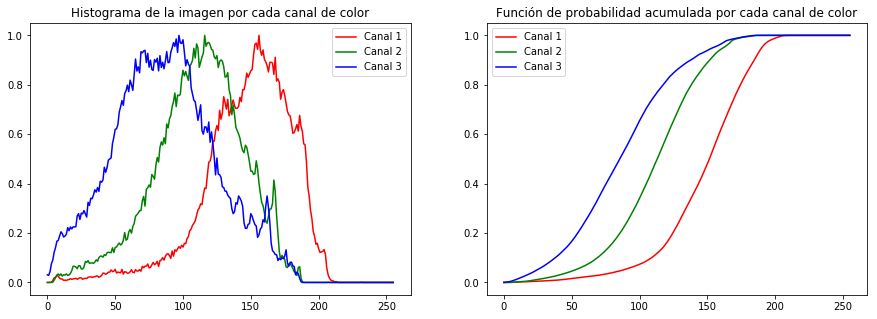

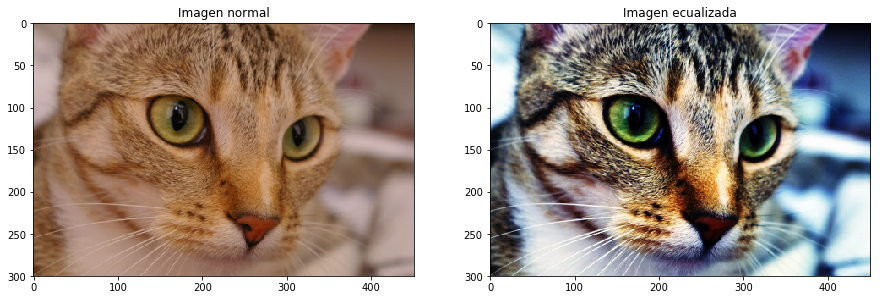

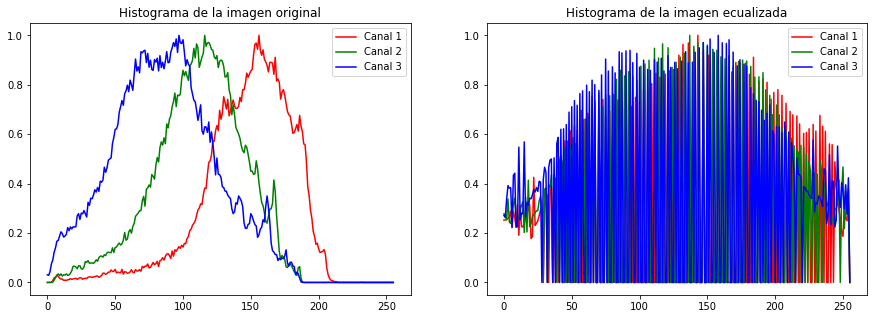

In [5]:
cat = data.chelsea()
process(cat)

En el último histograma podemos ver que los colores están distribuidos más uniformemente.
Ahora haremos lo mismo con una imagen en escala de grises.

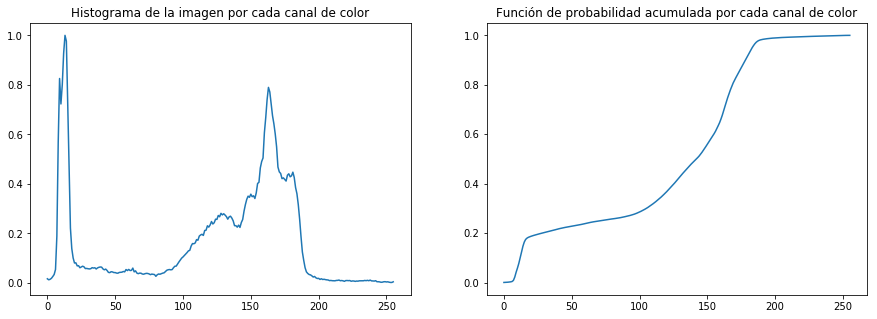

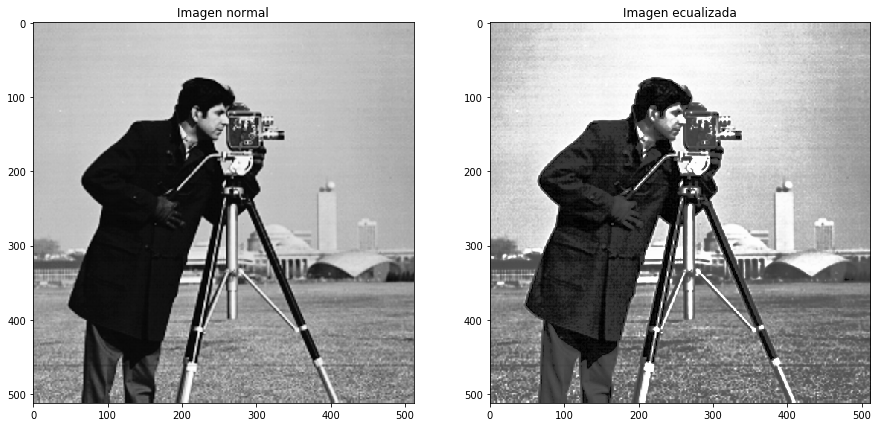

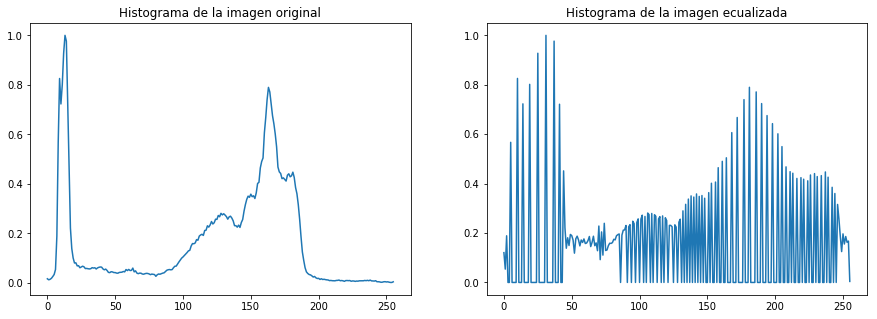

In [6]:
camera = data.camera()
process(camera)

En esta parte se usará la librería numba para comparar los tiempos de ejecución de la función $\textit{process}$ con y sin la optimización que provee esta librería.

Función $\textit{process}$ sin numba.

Tiempo transcurrido: 611 ms.


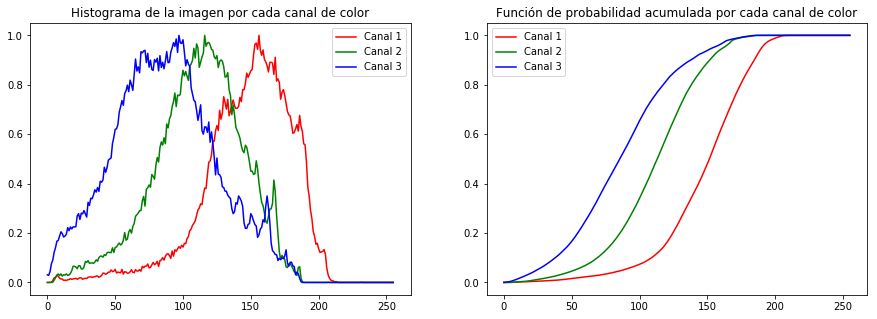

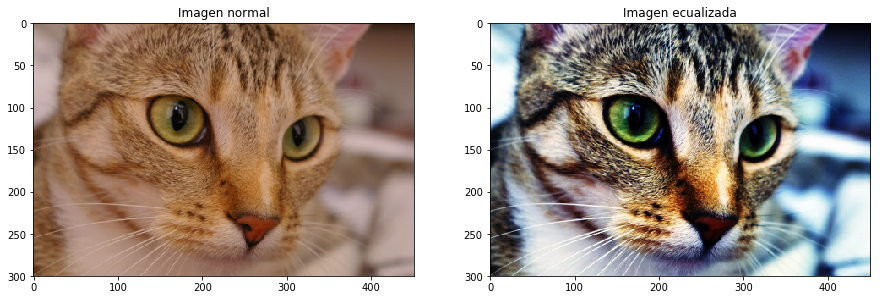

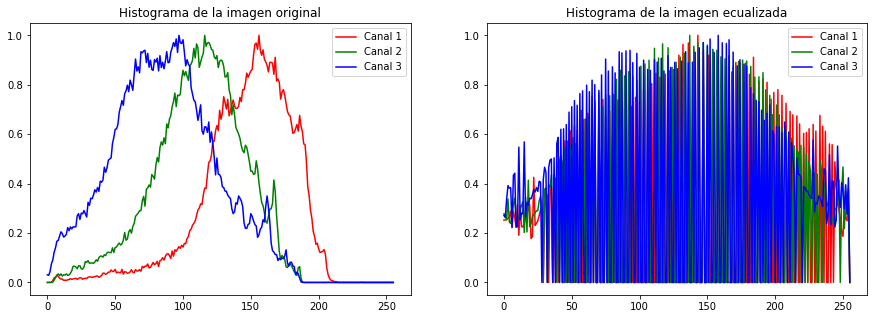

In [9]:
import time

init = round(time.time() * 1000)
cat = data.chelsea()
process(cat)
end = round(time.time() * 1000)

print("Tiempo transcurrido: " + str(end - init) + " ms.")

Ahora se hará lo mismo usando numba, para ello habrá que redefinir las funciones usando la bandera $\textbf{jit}$.

In [19]:
from numba import jit

@jit
def histogram(img, channel):
    data = np.zeros(256, dtype = 'int')
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if channel != -1:
                data[img[i, j, channel]] += 1
            else:
                data[img[i, j]] += 1
    
    return data

@jit
def create_paf(img, channel):
    n, m = img.shape[0], img.shape[1]
    hist = histogram(img, channel)
    data_f = hist.astype(np.float)

    norm_hist = data_f / (n * m)
    P = np.zeros(256, dtype = 'float')
    P[0] = norm_hist[0]
    for i in range(1, 256):
        P[i] = P[i - 1] + norm_hist[i]
    
    return hist, P

@jit
def normalize(v):
    mmax = v.max()
    res = np.array(v, dtype = 'float')
    res /= mmax
    
    return res

@jit
def equalizate(img, cdf, channel):
    sk = np.uint8(255 * cdf)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if channel != -1:
                img[i, j, channel] = sk[img[i, j, channel]]
            else:
                img[i, j] = sk[img[i, j]]
    
    return img

In [20]:
@jit
def process(img):
    x = np.linspace(0, 255, 256)
    
    fig1 = plt.figure(figsize = (15, 5))
    fig2 = plt.figure(figsize = (15, 8))
    fig3 = plt.figure(figsize = (15, 5))
    ax1 = fig1.add_subplot(1, 2, 1)
    ax2 = fig1.add_subplot(1, 2, 2)
    iax1 = fig2.add_subplot(1, 2, 1)
    iax2 = fig2.add_subplot(1, 2, 2)
    cax1 = fig3.add_subplot(1, 2, 1)
    cax2 = fig3.add_subplot(1, 2, 2)
    
    if img.ndim == 3:
        #Imagen a color
        c_color = ['red', 'green', 'blue']
        img_ec = np.array(img)
        for i in range(3):
            hist, cdf = create_paf(img, i)
            ax1.plot(x, normalize(hist), label = "Canal " + str(i + 1), color = c_color[i])
            cax1.plot(x, normalize(hist), label = "Canal " + str(i + 1), color = c_color[i])
            ax2.plot(x, cdf, label = "Canal " + str(i + 1), color = c_color[i])
            
            #Ecualizar
            img_ec = equalizate(img_ec, cdf, i)
        
        #Histograma de la función ecualizada
        for i in range(3):
            hist_ec, _ = create_paf(img_ec, i)
            cax2.plot(x, normalize(hist_ec), label = "Canal " + str(i + 1), color = c_color[i])
            
        iax1.imshow(img)
        iax2.imshow(img_ec)
        ax1.legend()
        ax2.legend()
        cax1.legend()
        cax2.legend()
        ax1.set_title("Histograma de la imagen por cada canal de color")
        ax2.set_title("Función de probabilidad acumulada por cada canal de color")
        cax1.set_title("Histograma de la imagen original")
        cax2.set_title("Histograma de la imagen ecualizada")
        iax1.set_title("Imagen normal")
        iax2.set_title("Imagen ecualizada")
            
    else:
        img_ec = np.array(img)
        hist, cdf = create_paf(img, -1)
        ax1.plot(x, normalize(hist))
        cax1.plot(x, normalize(hist))
        ax2.plot(x, cdf)
            
        #Ecualizar
        img_ec = equalizate(img_ec, cdf, -1)
        
        #Histograma de la función ecualizada
        hist_ec, _ = create_paf(img_ec, -1)
        cax2.plot(x, normalize(hist_ec))
            
        iax1.imshow(img, cmap = cm.Greys_r)
        iax2.imshow(img_ec, cmap = cm.Greys_r)
        ax1.set_title("Histograma de la imagen por cada canal de color")
        ax2.set_title("Función de probabilidad acumulada por cada canal de color")
        cax1.set_title("Histograma de la imagen original")
        cax2.set_title("Histograma de la imagen ecualizada")
        iax1.set_title("Imagen normal")
        iax2.set_title("Imagen ecualizada")

Ahora se hará la misma prueba con el código optimizado.

Tiempo transcurrido: 160 ms.


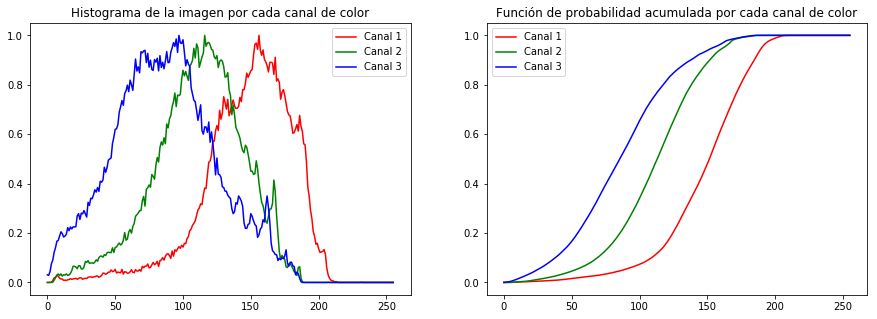

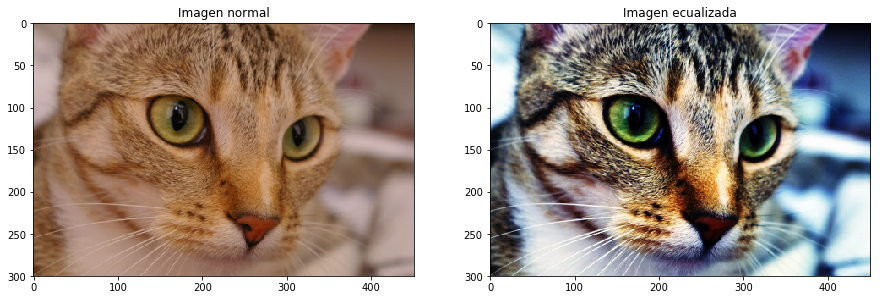

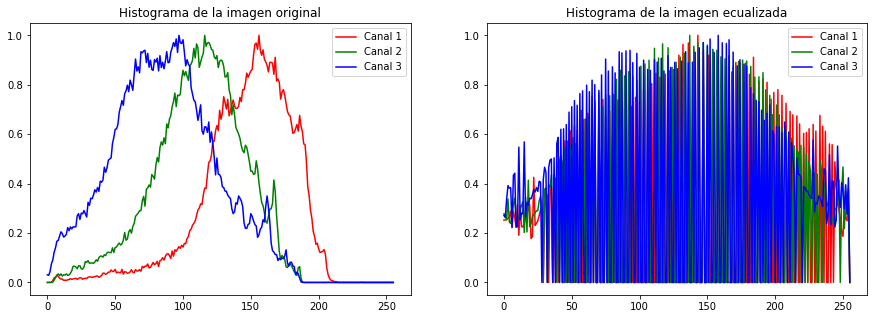

In [22]:
init = round(time.time() * 1000)
cat = data.chelsea()
process(cat)
end = round(time.time() * 1000)

print("Tiempo transcurrido: " + str(end - init) + " ms.")

Se nota una clara optimización que tarda mucho menos que el tiempo de la anterior ejecución. Al principio se puede tardar más en ejecutarse debido a la fase de compilación pero las siguientes ejecuciones se harán de manera más rápida.